In [1]:
import numpy as np
import scipy as sp
import sympy
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as legendre

from genquad import *
from testproblems import *
from functionfamiliy import *

Generate test example

In [2]:
eps_disc = 1e-8
eps_comp = 1e2*eps_disc
eps_quad = None
I = Interval(1e-6,1)
function_family = poly_and_sing_problem(I, number_of_functions = 10, degree = 6, scale = 10)
xx = np.linspace(I.a,I.b,1000)

1/x
-0.9789089160485*x**5 + 3.27611973277111*x**4 - 9.19417439648656*x**3 + 0.941156869355406*x**2 + 7.75863195661995*x + 3.37039460497638
-5.98879540978888*x**5 + 2.15435474669542*x**4 + 3.29950695954409*x**3 - 6.48118388409524*x**2 - 6.50250900972439*x - 6.41408688780561
-8.05377728993082*x**5 + 5.93776867687025*x**4 + 8.07939860512567*x**3 + 0.236297472632327*x**2 + 6.04535355441324*x + 3.02236423618338
-5.93956598101616*x**5 - 5.56483078929237*x**4 + 8.15165877970036*x**3 + 5.88118074831236*x**2 + 6.93129136195059*x - 5.31360321070326
2.60779515318139*x**5 - 3.94651356205515*x**4 - 5.89054331170602*x**3 - 0.607090311214435*x**2 - 7.14265053643722*x + 3.42081800308778
-6.90100336419549*x**5 - 4.16857914130439*x**4 - 0.0487587552477819*x**3 - 6.331314297875*x**2 - 3.21386805612516*x - 0.344769067015853
-4.12612284131972*x**5 - 9.03774738494364*x**4 - 5.42457512276232*x**3 + 4.88817333906597*x**2 - 1.58134146253214*x - 5.01245425756558
-4.83107973143861*x**5 - 3.08844753401712*x**4 - 

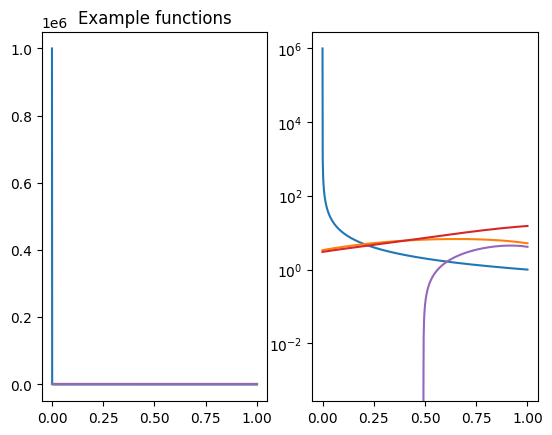

In [3]:
plt.figure("Example functions")
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
for phi in function_family.functions[:min(len(function_family.functions),functions_to_plot)]:
    plt.plot(xx,phi(xx))
plt.subplot(1, 2, 2)
for phi in function_family.functions[:min(len(function_family.functions),functions_to_plot)]:
    plt.semilogy(xx,phi(xx))

Discretize and compress

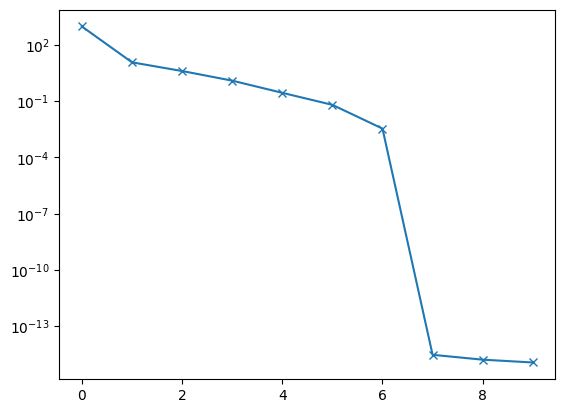

In [4]:
x, w, endpoints = adaptive_discretization(function_family, precision=eps_disc, k=30, verbose=False)
U, A, rank = compress_sequence_of_functions(function_family, x, w, precision=eps_comp)
Q,R,perm = sp.linalg.qr(A, pivoting = True)
plt.semilogy(np.abs(np.diag(R)),"-x")

(1e-06, 1.0)

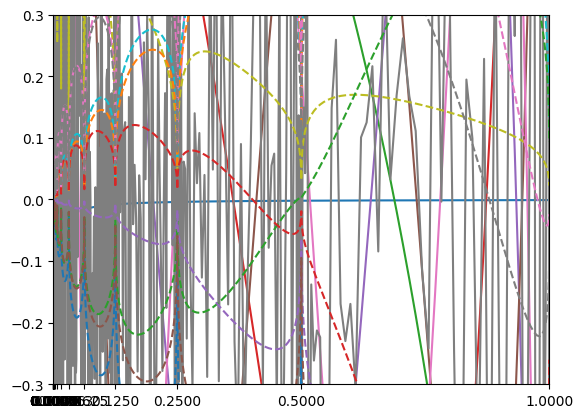

In [5]:
plt.figure();
plt.xticks(endpoints);
plt.plot(x,U);
plt.plot(x,A,"--");
plt.ylim(-0.3,0.3)
plt.xlim(I.a,I.b)

Chebyshev

In [6]:

r = U.T@w
k = len(r)

B = np.sqrt(w)*U.T
Q,R,perm = sp.linalg.qr(B, pivoting=True)
z = np.linalg.solve(R[:k,:k], Q.T@r) ## No Hermetian transpose in python? For now only support real functions.

print(z)
idx = perm[:k]
x_cheb = x[idx]
w_cheb = z*np.sqrt(w[idx])

[ 0.21144191  0.84784843  1.47706444  2.31858405 -0.06048177  3.37690719
  2.80934917  3.62596603]


Single function test

5.75695503076417 5.756955030764172 5.756955030764171


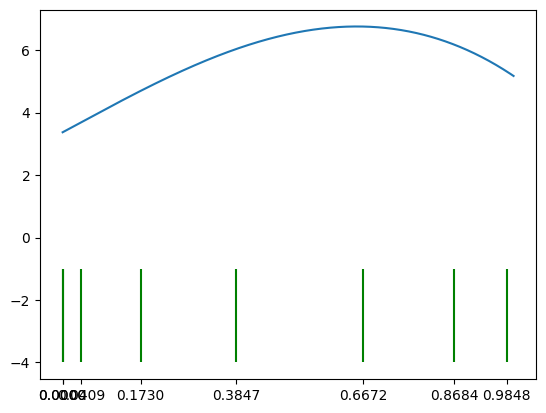

In [10]:
k = 1
phi = function_family.functions[k]
plt.plot(xx,phi(xx));
plt.xticks(x_cheb)
plt.vlines(x = x_cheb, ymin=-4, ymax=-1, colors = 'green',)
print(function_family.analytic_integrals[k], phi(x)@w, phi(x_cheb)@w_cheb)

In [8]:
print(A.shape)
print(A)

(1140, 10)
[[ 6.20822934e+01  2.09557547e-04 -3.98801547e-04 ... -3.11653575e-04
   4.69243047e-04  4.77013010e-04]
 [ 9.40630798e+01  3.19545612e-04 -6.08115934e-04 ... -4.75227606e-04
   7.15529252e-04  7.27377343e-04]
 [ 1.16454735e+02  4.00144444e-04 -7.61500702e-04 ... -5.95094015e-04
   8.96006818e-04  9.10843340e-04]
 ...
 [ 4.30923487e-02  2.23420264e-01 -8.53376661e-01 ... -8.65198816e-01
  -4.08183610e-02 -1.62085177e-01]
 [ 3.43603760e-02  1.77915669e-01 -6.83082279e-01 ... -6.94275583e-01
  -3.50065146e-02 -1.31452698e-01]
 [ 2.25144989e-02  1.16492696e-01 -4.48549155e-01 ... -4.56532327e-01
  -2.38408163e-02 -8.69452425e-02]]
